In [1]:
import sys

sys.path.append('..')

import numpy as np
import json
from systems import CARModel
from lightning_module import PreTrainLightning
from models import TSMVAE
import torch
import pandas as pd
from matplotlib import pyplot as plt

from inference_utils import load_pretrained_model

In [2]:
df = pd.read_csv('/home/jp4474/Bcell_fate_imm_resp/output/Branched_timeinflux_samples.csv', comment='#')

In [3]:
df[['alpha', 'beta', 'mu', 'delta', 'lambda_WT', 'nu']].mean()

alpha        0.112483
beta         0.010080
mu           0.000355
delta        0.919345
lambda_WT    0.075981
nu           0.005347
dtype: float64

In [4]:
folder_name = '/home/jp4474/viaABC/CAR_d64_ed32_6_4_4_4_vae_mask_0.15_beta_0.01_noise_0.1'
model = load_pretrained_model(
    model_class=TSMVAE,
    lightning_class=PreTrainLightning,
    checkpoint_substr="TSMVAE",
    folder_name=folder_name,)

Successfully loaded model


In [5]:
car_abc = CARModel(model=model)

INFO:viaABC:Initializing viaABC class
INFO:viaABC:Model updated
INFO:viaABC:viaABC class initialized with the following parameters:
INFO:viaABC:num_parameters: 6
INFO:viaABC:Mu: [0 0 0 0 0 0]
INFO:viaABC:Sigma: [1 1 1 1 1 1]
INFO:viaABC:t0: 4
INFO:viaABC:tmax: 30
INFO:viaABC:time_space: [ 4  7  9 14 17 22 26 30]
INFO:viaABC:pooling_method: no_cls
INFO:viaABC:metric: pairwise_cosine


In [6]:
scaled_observational_data = car_abc.preprocess(car_abc.observational_data)
with torch.no_grad():
    pred = model(torch.from_numpy(scaled_observational_data).float().unsqueeze(0).to(model.device), mask_ratio = 0.0)[-1].squeeze(0).cpu().numpy()

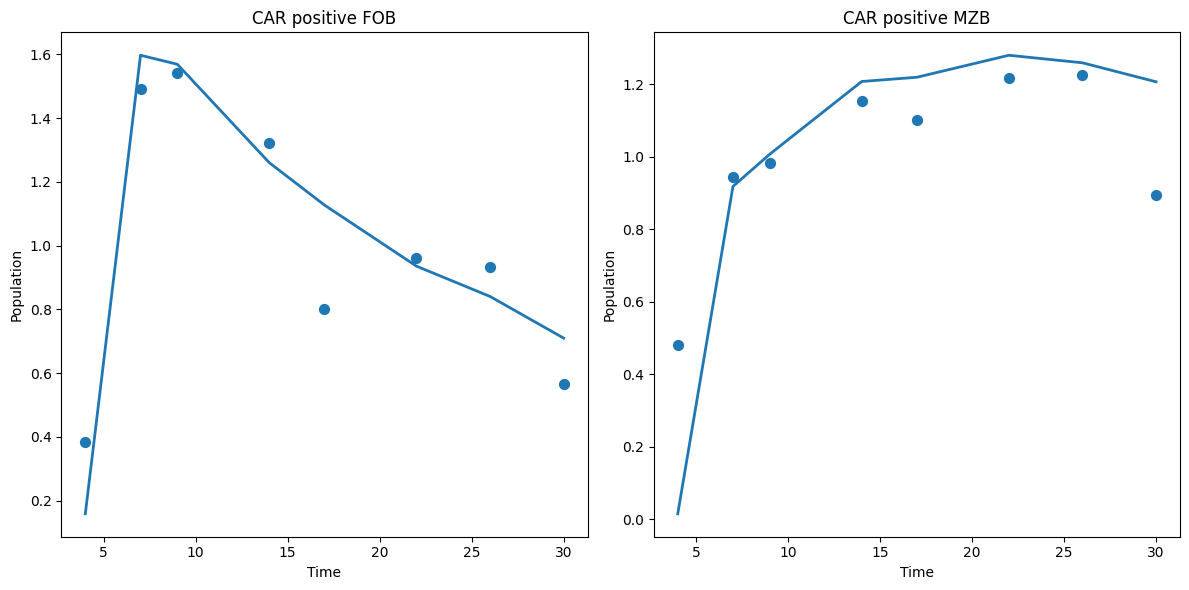

In [7]:
# plot pred as lines, observational_data as points
plt.figure(figsize=(12, 6))

# Plot both species (variables) separately
plt.subplot(1, 2, 1)
plt.plot(car_abc.time_space, pred[:, 0], label='Reconstruction', linewidth=2)
plt.scatter(car_abc.time_space, scaled_observational_data[:, 0], label='Observational Data', s=50)
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('CAR positive FOB')

plt.subplot(1, 2, 2)
plt.plot(car_abc.time_space, pred[:, 1], label='Reconstruction', linewidth=2)
plt.scatter(car_abc.time_space, scaled_observational_data[:, 1], label='Observational Data', s=50)
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('CAR positive MZB')

plt.tight_layout()
plt.show()

In [8]:
generations = np.load(f'{folder_name}/car_5_no_cls_pairwise_cosine_1000_1.npz', allow_pickle=True)['generations']

In [89]:
last_generation = generations[17]

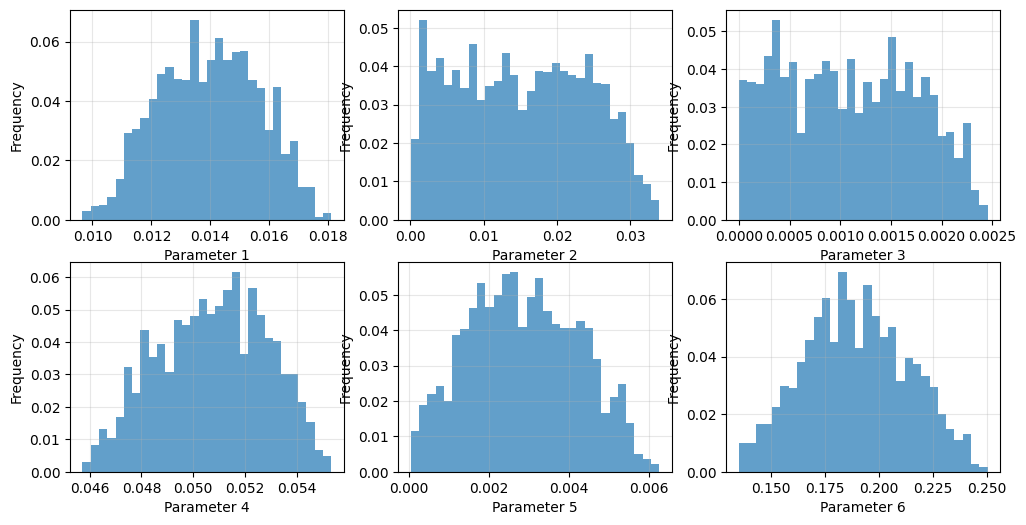

In [90]:
# plot a histogram of the 6 parameters in the last generation
particles = last_generation['particles']
weights = last_generation['weights']

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.hist(particles[:, i], weights=weights, bins=30, alpha=0.7, label='Posterior Distribution')
    plt.xlabel(f'Parameter {i+1}')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

In [91]:
means = np.average(particles, axis=0, weights=weights)

In [92]:
# means = df[['alpha', 'beta', 'mu', 'delta', 'lambda_WT', 'nu']].mean()

In [93]:
means

array([0.01396337, 0.01521354, 0.00108469, 0.0507471 , 0.00287949,
       0.18947152])

In [94]:
parameters = np.array([0.05, 0.010869, 0.000355, 0.92, 0.076, 0.005843])
#parameters = np.array([0.50460082, 0.51981766, 0.50347073, 0.07728561, 0.03903801, 0.41433539])
time_space = np.linspace(4, 30, 1000)
y_stan,_ = car_abc.simulate(df[['alpha', 'beta', 'mu', 'delta', 'lambda_WT', 'nu']].mean().values, time_space)
y,_ = car_abc.simulate(means, time_space)

In [95]:
WT_df = pd.read_csv("/home/jp4474/viaABC/data/BCELL/WT_imm_data.csv")

Text(0.5, 25.722222222222214, 'Time')

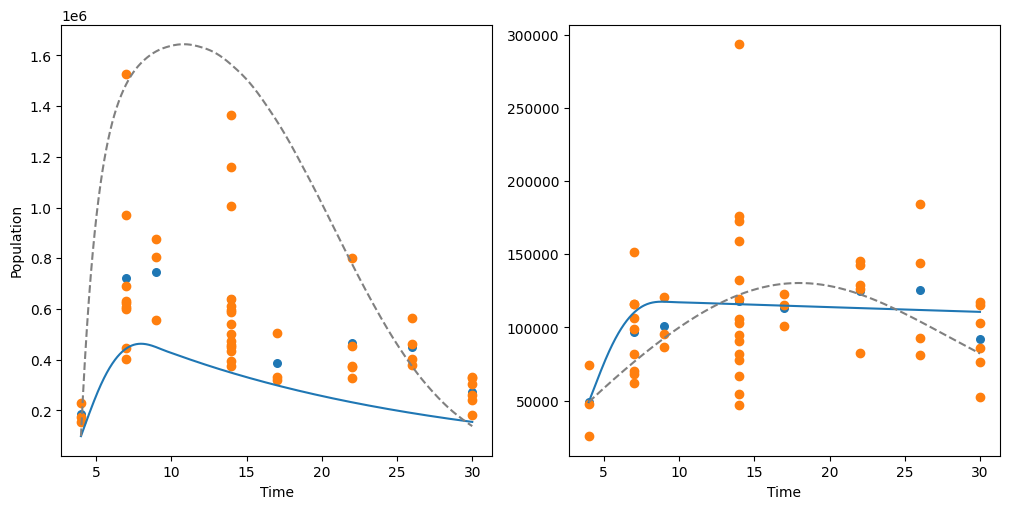

In [96]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(time_space, y[:,0])
ax[0].plot(time_space, y_stan[:,0], linestyle='--', color='gray')
ax[0].scatter(car_abc.time_space, car_abc.observational_data[:, 0], s=30)
ax[0].scatter(WT_df['days_post_imm'], WT_df['CARpos_FoB'])
# ax[0].plot(time_space, y[:, 0], label="Inferred", color='black', linestyle='--')

ax[1].plot(time_space, y[:,1], label="Predator")
ax[1].plot(time_space, y_stan[:,1], linestyle='--', color='gray')
ax[1].scatter(car_abc.time_space, car_abc.observational_data[:, 1], s=30)
ax[1].scatter(WT_df['days_post_imm'], WT_df['CARpos_MZB'])
# ax[1].plot(time_space, y[:, 1], label="Inferred", color='black', linestyle='--')

plt.tight_layout()
ax[0].set_ylabel("Population")
ax[0].set_xlabel("Time")
ax[1].set_xlabel("Time")

Text(0.5, 25.722222222222214, 'Time')

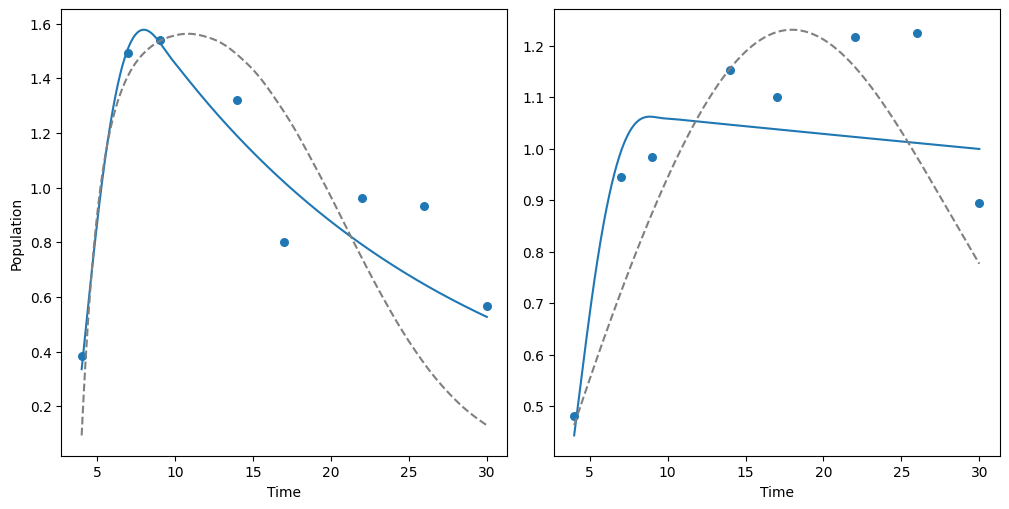

In [97]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(time_space, car_abc.preprocess(y[:, 0]))
ax[0].scatter(car_abc.time_space, car_abc.preprocess(car_abc.observational_data)[:,0], s=30)
ax[0].plot(time_space, car_abc.preprocess(y_stan[:, 0]), linestyle='--', color='gray')

ax[1].plot(time_space, car_abc.preprocess(y[:, 1]), label="Predator")
ax[1].scatter(car_abc.time_space, car_abc.preprocess(car_abc.observational_data)[:,1], s=30)
ax[1].plot(time_space, car_abc.preprocess(y_stan[:, 1]), linestyle='--', color='gray')

plt.tight_layout()
ax[0].set_ylabel("Population")
ax[0].set_xlabel("Time")
ax[1].set_xlabel("Time")

In [98]:
len(time_space)

1000

In [99]:
trajectories = np.zeros((len(particles), 2, len(time_space)))
for i in range(1000):
    #idx = np.random.choice(np.arange(0, 1000, 1), size=1, p=weights)
    param_set = np.array(particles[i])
    solution, _ = car_abc.simulate(param_set, time_space)
    trajectories[i] = solution.T

In [100]:
trajectories.shape

(1000, 2, 1000)

In [101]:
alpha = 0.95
lower_bound = np.percentile(trajectories, (1-alpha)/2*100, axis=0)
upper_bound = np.percentile(trajectories, (1+alpha)/2*100, axis=0)
median_trajectory = np.percentile(trajectories, 50, axis = 0)

Text(0.5, 25.722222222222214, 'Time')

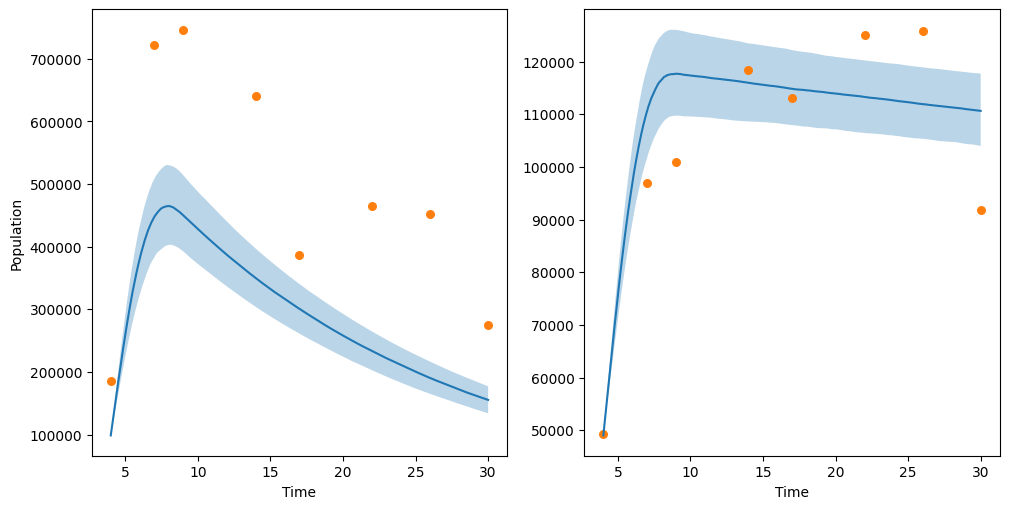

In [102]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(time_space, median_trajectory[0])
ax[0].fill_between(time_space, lower_bound[0], upper_bound[0], alpha=0.3)
ax[0].scatter(car_abc.time_space, car_abc.observational_data[:, 0], s=30)
# ax[0].plot(time_space, y[:, 0], label="Inferred", color='black', linestyle='--')

ax[1].plot(time_space, median_trajectory[1], label="Predator")
ax[1].fill_between(time_space, lower_bound[1], upper_bound[1], alpha=0.3)
ax[1].scatter(car_abc.time_space, car_abc.observational_data[:, 1], s=30)
# ax[1].plot(time_space, y[:, 1], label="Inferred", color='black', linestyle='--')

plt.tight_layout()
ax[0].set_ylabel("Population")
ax[0].set_xlabel("Time")
ax[1].set_xlabel("Time")

In [103]:
scaled_trajectory = [car_abc.preprocess(x.T).T for x in trajectories]
lower_bound = np.percentile(scaled_trajectory, (1-alpha)/2*100, axis=0)
upper_bound = np.percentile(scaled_trajectory, (1+alpha)/2*100, axis=0)
median_trajectory = np.percentile(scaled_trajectory, 50, axis = 0)

Text(0.5, 25.722222222222214, 'Time')

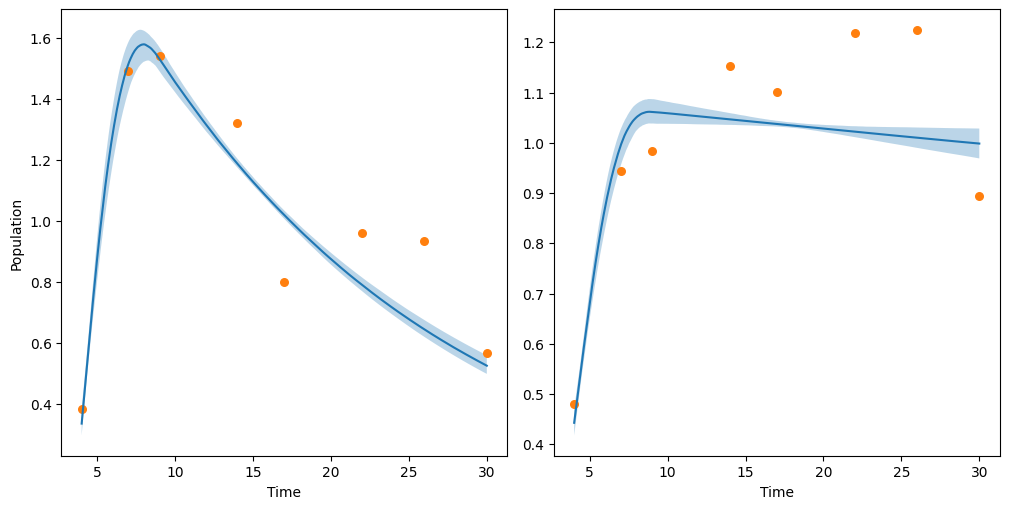

In [104]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(time_space, median_trajectory[0])
ax[0].fill_between(time_space, lower_bound[0], upper_bound[0], alpha=0.3)
ax[0].scatter(car_abc.time_space, car_abc.preprocess(car_abc.observational_data[:, 0]), s=30)
# ax[0].plot(time_space, y[:, 0], label="Inferred", color='black', linestyle='--')

ax[1].plot(time_space, median_trajectory[1], label="Predator")
ax[1].fill_between(time_space, lower_bound[1], upper_bound[1], alpha=0.3)
ax[1].scatter(car_abc.time_space, car_abc.preprocess(car_abc.observational_data[:, 1]), s=30)
# ax[1].plot(time_space, y[:, 1], label="Inferred", color='black', linestyle='--')

plt.tight_layout()
ax[0].set_ylabel("Population")
ax[0].set_xlabel("Time")
ax[1].set_xlabel("Time")